In [1]:
import numpy as np
!pip install keras
!pip install tensorflow
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
def preprocess_data(x, y, limit=None):
    
    # Flatten the 28x28 images into 784x1
    x = x.reshape(x.shape[0], 784, 1)
    
    # Normalize the pixel values to the range [0, 1]
    x = x.astype("float32") / 255
    
    # One-hot encode the labels
    y = to_categorical(y, 10)  # Convert labels to one-hot encoding
    y = y.reshape(y.shape[0], 10, 1)  # Reshape for compatibility
    
    if limit:
        return x[:limit], y[:limit]
    return x, y

In [4]:
# Preprocess the training data
x_train, y_train = preprocess_data(train_images, train_labels, limit=5000)

In [5]:
class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward_propagation(self, input):
        self.input = input
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    def backward_propagation(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        input_gradient = np.dot(self.weights.T, output_gradient)
        return input_gradient
    

In [6]:
class Activation():
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [7]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax():
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)
        
class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)


In [8]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [9]:
network = [
    Dense(784, 128),  # Input layer: 784 -> 128 neurons
    Tanh(),
    Dense(128, 64),   # Hidden layer: 128 -> 64 neurons
    Tanh(),
    Dense(64, 10),    # Output layer: 64 -> 10 neurons (for digits 0-9)
    Softmax()
]

In [10]:
def train(network, loss, loss_prime, x_train, y_train, count=100, learning_rate=0.1):
    for e in range(count):
        error = 0
        for x, y in zip(x_train, y_train):
            # Forward pass
            output = x
            for layer in network:
                output = layer.forward_propagation(output) if isinstance(layer, Dense) else layer.forward(output)

            # Compute loss
            error += loss(y, output)

            # Backward pass (error)
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward_propagation(grad, learning_rate) if isinstance(layer, Dense) else layer.backward(grad, learning_rate)

        # Print error for every epoch
        print(f"Epoch {e + 1}/{count}, error={error}")

In [11]:
# Train the network
train(network, mse, mse_prime, x_train, y_train, count=500, learning_rate=0.1)

Epoch 1/500, error=699.4749651326889
Epoch 2/500, error=544.1020228010846
Epoch 3/500, error=444.4006489866411
Epoch 4/500, error=375.8843373107039
Epoch 5/500, error=312.97370396774096
Epoch 6/500, error=277.26335924681
Epoch 7/500, error=253.15371142206615
Epoch 8/500, error=231.97239415245085
Epoch 9/500, error=219.69455771242588
Epoch 10/500, error=206.99457199976777
Epoch 11/500, error=190.40536758697985
Epoch 12/500, error=169.89016273240853
Epoch 13/500, error=142.7536935172366
Epoch 14/500, error=128.233608787812
Epoch 15/500, error=111.33608082444388
Epoch 16/500, error=100.30445573621355
Epoch 17/500, error=91.59487868002864
Epoch 18/500, error=82.5721917853805
Epoch 19/500, error=68.32246973955584
Epoch 20/500, error=65.45202477922307
Epoch 21/500, error=58.96620061672762
Epoch 22/500, error=56.13308041564442
Epoch 23/500, error=51.52557709321295
Epoch 24/500, error=47.55438148856645
Epoch 25/500, error=43.033064908664265
Epoch 26/500, error=41.0604389440955
Epoch 27/500, er

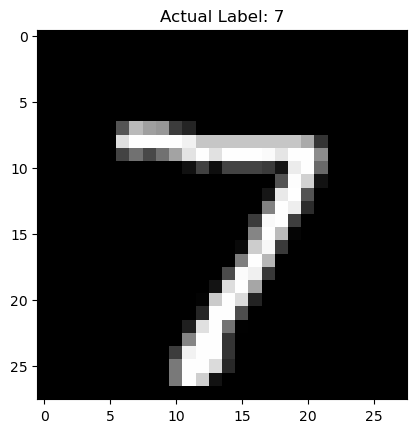

Predicted Label: 7


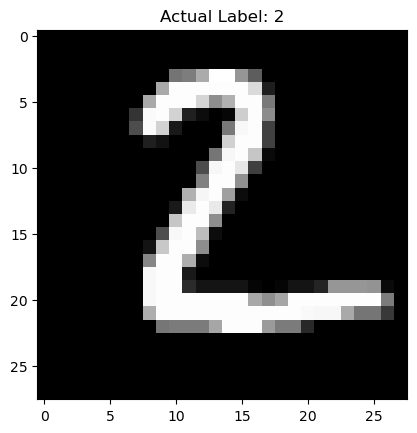

Predicted Label: 2


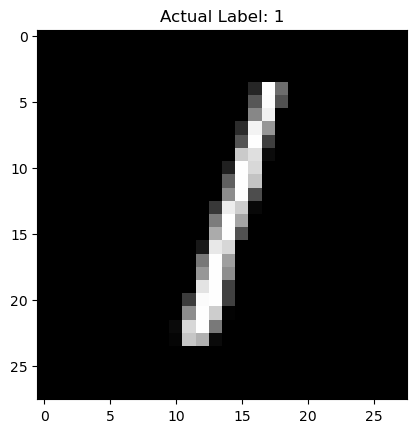

Predicted Label: 1


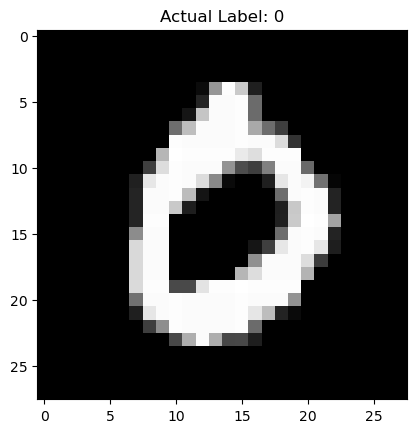

Predicted Label: 0


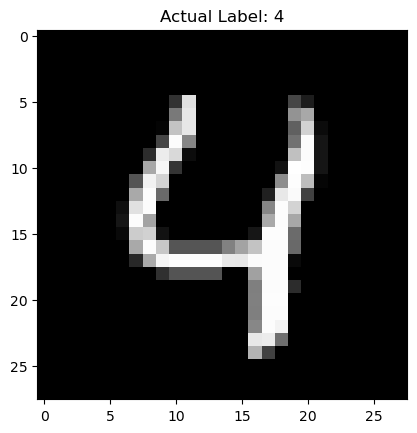

Predicted Label: 4


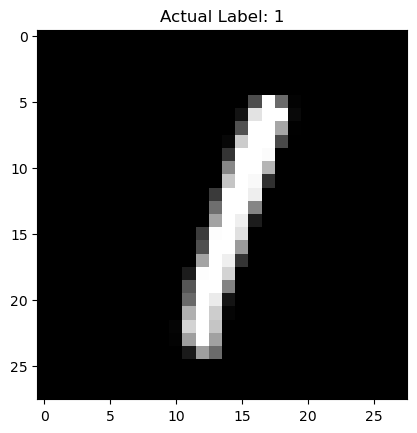

Predicted Label: 1


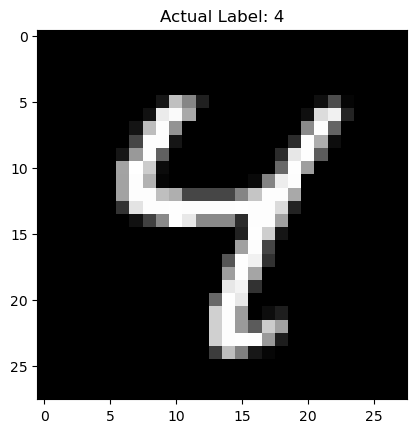

Predicted Label: 4


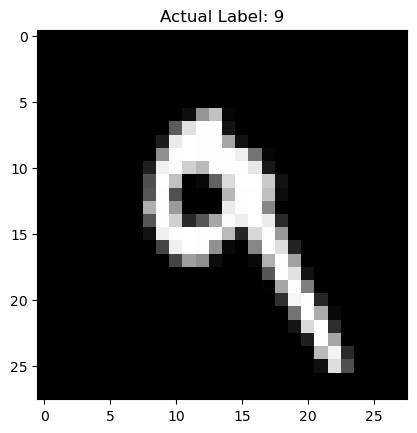

Predicted Label: 9


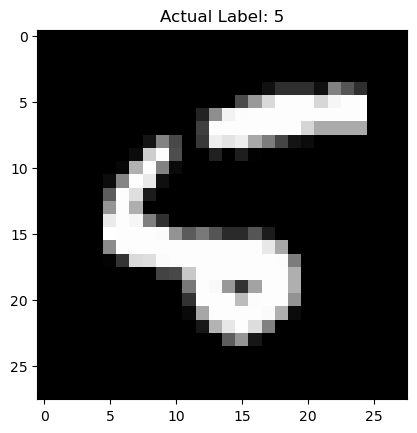

Predicted Label: 4


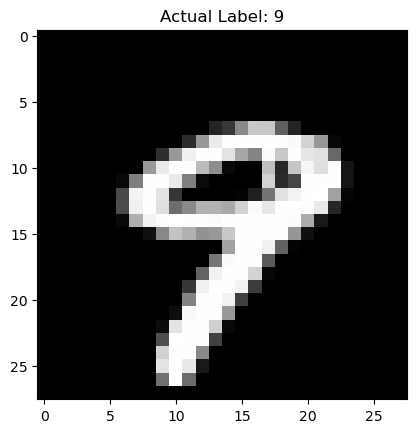

Predicted Label: 9


In [14]:
# Loop through test samples and display results
for x, y in zip(x_test, y_test):
    # Get network's output (predicted)
    output = predict(network, x)

    # Display the image (reshaping it back to 28x28)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title('Actual Label: {}'.format(np.argmax(y)))  # Show actual label
    plt.show()

    # Print the predicted label
    print('Predicted Label:', np.argmax(output))
